# Tutorial on Modeling of Learning Under Uncertainty

In this tutorial, you will be introduced to three modeling papers on reinforcement learning. These papers study the phenomenon of organizationa learning under uncertainty trough the use of agent based models who learn from n-Arm bandits.

The models we will study are:
1. March and Denrell (2001)
This paper introduced the so called Hotstove effect. The idea being that if agents choose between two options with the same mean, one with variance in its feedback and one without, the agents will learn to choose the variant without variance.

2. Posen and Levinthal (2012)
This paper expands the model from Denrell and March (2001) and studies how agents learn in an environment with ten options, all of them with variance. It studies the effects of different shocks and environmental changes as agents chase a moving target.

3. Puranam and Swamy (2016)
This paper expands the model from Denrell and March (2001) through the process of coupled learning. Two agents, not one as before, learn of the perfoemance of two options. The catch is that the performance is based upon their coupled action and the agetns do not know what the other agent is doing. Through time the agents learn to cooperate. Interestingly, if agents start with the same choice, they reach the optimal choice faster than if they started with mixed choices. This holds even if they start choosing the wrong option.

# Basic Building Blocks

In this first sections, I will present the basic building blocks. Namely, the àgent's learning and decision processes and how we generate options in the environment.

## Agents
The agents follow a few simple actions. 

### 1. Choose
The agents choose one option based upon their attraction to this option. In this model, we use softmax as the rule for transforming the different attractions for each option into probabilities of choosing one option. Other rules as greedy and e-greedy are possible. The agent's level of exploration is determined by the parameter tau. A small tau leads to high exploitation, a high tau to infinite exploration. Due to limitations in the floating point operation we cannot use taus lower that 0.002.

### 2. Update
Updating is done via the Bush-Mossteller equation. The parameter phi determins how much the agent updates its beliefs based upon new information. A value of zero leads to agents to not update their beliefs. A value of one to full update of beliefs. A mixture leads to what is known as an Exponentially Recency Weighted Average (Sutton and Barto, 1998). In Denrell and March (2001) and Puranam and Swamy (2016), we use a constant phi value. Posen and Levinthal use a varying phi for every trial. The phi varies according to 1/(ki+1) where ki is the number of times an option has been tried. 

### 3. Learn
Learn is a subroutine. It receives two parameters, the number of periods and the bandits to learn from. 
It initalizes two lists and starts a for loop that run for the specified number of periods.
The period starts by asking the agent to choose an option. The payoff of the option is calculated by measuring the option's value. This is explained in the next section. The period ends with the updating of the agent's attractions and the storage of the choice and payoff. After this a new period starts, the choices are stored and returned to the user.

### 4. Reset
This function resets the attractions of the agent. It takes one value, the number of bandits in the environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(tau, attraction): #softmax action selection with attraction vector as parameters
    denom = np.sum(np.exp((attraction[:])/tau))
    probabilities = np.exp(attraction/tau)/denom
    choice = np.random.choice(range(len(probabilities)), p = probabilities)
    return(choice)

class agent:
    def __init__(self, tau, phi, style_update, style_choose, e = 0.0):
        self.tau = tau
        self.phi = phi
        self.style_update = style_update
        self.style_choose = style_choose
        self.e = e
    def update(self, choice, payoff):
        if self.style_update == "constant": self.attraction[choice] += self.phi*(payoff-self.attraction[choice])
        elif self.style_update == "over k":
            self.times[choice] += 1 #starts in 1
            self.attraction[choice] += (payoff-self.attraction[choice])/(self.times[choice]+1) # divides by 2
    def choose(self):
        if self.style_choose == "softmax": choice = softmax(self.tau, self.attraction)
        elif self.style_choose == "greedy": choice = np.argmax(self.attraction)
        elif self.style_choose == "e-greedy": 
            best_choice = np.argmax(self.attraction)
            other_choise = np.random.choice(range(self.attaction))
            choice = np.random.choice([best_choice,other_choice], p = [1-e,e])
        return(choice)
    def learn(self, num_periods, bandits):
        choices = []
        payoffs = []
        knowledge = []
        for i in range(num_periods):
            choice = self.choose()
            payoff = bandits.measure(choice)
            nugget = 1-sum((self.attraction-bandits.means)**2)
            self.update(choice, payoff)
            choices.append(choice)
            payoffs.append(payoff)
            knowledge.append(nugget)
        return([choices, payoffs, knowledge])
    def reset(self, num_bandits):
        self.attraction = np.ones(num_bandits)/2.0
        if self.style_update == "over k": self.times = np.zeros(num_bandits)

## Environment
The environment is composed of an n-arm bandit. Each arm of the bandit is definied by an object of class bandit. Put together these objects create one object of class bandits. 

### Bandit
The bandit is a simple structure. It has a mean and a standard deviation. The style determines whether the bandit outputs an uniformly distributed value, a normally distributed value, or one without noise.

#### Measure
The bandits perform one function, when called upon, they give one output, centered around a mean value and with an added noise. The style of bandit determines where the noise is drawn upon.

### Bandits_D_M
This class creates the environment for the Denrell and March (2001) paper. In specific, two bandits. One with stable output and one with variable output. Both bandits have the same mean.

#### Measure
This is a wrapper function. The objective is that the agents ask the bandits class and not the specific bandit for the measurement. Then the bandits class is in charge of asking its bandit for the performance value. 

In [2]:
class bandit:
    def __init__(self, mu, stdev, style):
        self.style = style
        self.mean = mu
        self.stdev = stdev
        if style == "Beta": self.mean = np.random.beta(a=mu, b=stdev)
    def measure(self):
        if self.style == "Uniform":  value = self.mean+self.stdev*(np.random.random()-0.5)
        elif self.style == "Normal": value = np.random.normal(loc=self.mean, scale=self.stdev)
        elif self.style == "Beta": value = 2*np.random.binomial(n=1, p=self.mean)-1
        elif self.style == "Stable": value = self.mean
        return(value)
        
class bandits_D_M:
    def __init__(self, noise):
        self.arms = []
        self.means = [0.5, 0.5]
        self.arms.append(bandit(mu = 0.5, stdev = noise, style = "Uniform")) #0.622 equiprobability at 100 periods # 0.6392 0.5 expected value at 1000 periods
        self.arms.append(bandit(mu = 0.5, stdev = 0.0, style = "Stable")) # noise = 0.0 is a redundancy
    def measure(self, choice):
        return(self.arms[choice].measure())

### Denrell and March (2001)

With these two building blocks, we can run a simulation to replicate the main finding of Denrell and March (2001).

Reference: Denrell, J., & March, J. G. (2001). Adaptation as information restriction: The hot stove effect. Organization Science, 12(5), 523-538.

#### 1. Initialize values
We start by initailizing the attributes of the simulation. The agents are given a set of tau and phi. The agents will learn for 50 periods and the results replicated 2500 times. We specify the noise to be 1, that means the bandits will draw from values between 0 and 1. Changes in the tau, phi, noise, and bandit style should change the learning. Changes in the number of repetitions lead to more noisy results.

In [3]:
## Bandits
noise = 1.0
## Agents
num_bandits = 2
tau = 0.01/num_bandits
phi = 0.1
agent_style_update = "constant"
agent_style_choose = "softmax"
## Simulation
num_periods = 100
num_reps = 2500

#### 2. Initialize agent and Bandits
We create one agent, Alice and initialize the environment for the paper. The bandits are created by specifying first two agents one drawn from an uniform distribution and the second one from a stable value.

In [4]:
## Initialize agents
Alice = agent(tau = tau, phi = phi, style_update = style_update, style_choose = style_choose)
Alice.reset(num_bandits = num_bandits)
## Initialize bandits
options = bandits_D_M(noise = noise)

#### 3. Run simulation
Having the agent and environment we can run a simulation. We initialize two arrays, one for payoff and one for choices. Additionally, we create an empty list to store the last choices of the agents and one value to save the attraction to the option with variable output after every replication of the simulation is finished.

This takes some time.

In [5]:
all_payoffs = np.zeros(num_periods)
#all_knowledge = np.zeros(num_periods)
#all_RE = np.zeros(num_periods)
all_choices = np.zeros(num_periods)
all_attractions = 0.0
last_choices = []
for j in range(num_reps):
    Alice.reset(num_bandits = num_bandits)      
    choice, payoff, knowledge = Alice.learn(num_periods, options)
    all_payoffs += payoff
#    all_knowledge += knowledge          
    # Calculate exploration
#    all_RE[0] += 1
#    for i in range(len(choice)-1):
#        if choice[i+1]!=choice[i]: all_RE[i+1] +=1
    # Specific for this paper
    all_choices += choice
    all_attractions += Alice.attraction[0]
    last_choices.append(choice[-1])

#### 4. Display results

##### Choice as function of time
We present two plots. The first one presents the option chosen on every period. As on every period the agent can choose 0 or 1, what we plot in the y-axis is the number of times the stable option is chosen. As expected, the first period starts at 50% of the time and it increases towards a 100% as time goes by.


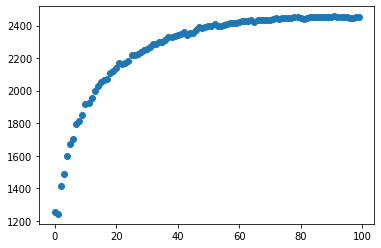

In [6]:
plt.scatter(range(num_periods), all_choices)

##### Performance as function of time
The second graph presents the average payoff. This looks like a funnel, narrowing from left to right. As the stable option is chosen more and more, the variance in the performanc decreases. 

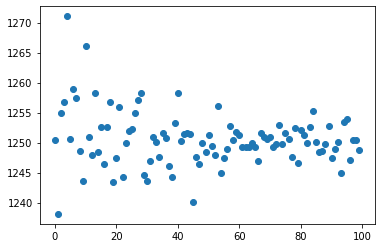

In [7]:
plt.scatter(range(num_periods), all_payoffs)

#### Summary variables
##### Percentage of time stability is chosen
Both options have the same performance. Nonetheless, the stable option is chosen 98% of the time after 50 periods. 

In [8]:
100*float(sum(last_choices))/num_reps

98.04

##### Expected attraction
At the end ofthe each replication, we stored the attraction each agent had for the variable option. Below we cane see that agents perceived the average performance of this option to be 0.464, much lower than the 0.5 it really has.  

In [9]:
all_attractions/num_reps

0.4642255526896892

#### 5. Exercise
Find the how high the mean of the variable option needs to be in order to be chosen 50% of the time at the end of the simulation. How does it related to the amount of noise in the option? How does it change if normal and not uniform noise is used? Or if we use the 1/(k+1) updating instead of constant updating?